In [3]:
### Date: 7th March 2018: 

### Implement a generalized Extended Kalman Filter class in Python: 

import numpy as np
from matplotlib import pyplot as plt

class KF:
    
    # Constructor: 
    def __init__(self, deltaT,  A, B, D, H, Q, R, x0 , P0):
        
        """
        Input Parameters: 
        1. deltaT - Time step of the Filter (sec)
        
        States: 
        x_hat[k] - Updated state at time instant k using measurements upto k
        x_bar[k] - Propagated state at k using measurements upto k-1
        
        P_hat[k]  - Updated state error covariance at time instant k using measurements upto k
        P_bar[k] -  Propagated state error covariance at k using measurements upto k-1
        
        Model Parameters: 
        A - Discrete State Dynamics Matrix
        B - Input matrix
        D - Process Noise Mapping matrix
        H - Measurement Matrix
        Q - Process Noise Covariance
        R - Measurement Noise Covariance
        """
        
        
        self.A = A
        self.B = B
        self.D = D
        self.H = H
        self.Q = Q
        self.R = R
        
        # Compute dimensions: 
        self.stateDim = self.x0.shape[0] 
        self.obsDim   = self.R.shape[0]
        
        
        # Internal Matrices and Vectors:
        
        self.x_hat = self.x0
        self.x_bar = np.zeros_like(self.x0)
        
        self.P_hat = self.P0
        self.P_bar = np.zeros_like(self.P0)
        
        self.S = np.zeros_like(self.R)
        self.K = np.zeros((stateDim, obsDim))
        self.innov = np.zeros((self.obsDim,1))
        
        # History of the state vector: 
        self.xHist = []
        self.xHist.append(self.x0)
        self.pHist = []
        self.pHist.append(self.P0)
        
        self.timer = 0       
        
        
    
    
    # 1. Function to propagate mean and covariance of the state vector: 
    def propagate(self, u): 
        
        self.x_bar = np.dot(self.A, self.x_hat) + np.dot(self.B,u)
        
        self.P_bar = np.dot( np.dot(self.A, self.P_hat), self.A.T) + np.dot( np.dot(self.D, self.Q), self.D.T)
        
        # Increment the timer:
        self.timer += self.deltaT
        
    # 3. Function to predict measurements: 
    def predict_measurements(self): 
        
        self.z_bar = np.dot(self.H, self.x_bar)
        
    # 4. Function to compute Kalman Gain: 
    def compute_K_gain(self): 
        
        self.S = np.dot( np.dot(self.H, self.P_bar), self.H.T) + self.R
        
        self.K = np.dot(np.dot(self.P_bar, self.H.T), np.linalg.inv(self.S))
        
        
    # 5. Function to update the state and covariance: 
    def update(self, z): 
        
        # Predict measurements:
        self.predict_measurements()
        
        # Compute the Kalman Gain:
        self.compute_K_gain()
        
        # Compute the innovations: 
        self.innov = z - self.z_bar
        
        # Update the estimated mean of the state: 
        self.x_hat = self.x_bar + np.dot(self.K , self.innov)
        
        # Update the estimated covariance of the state: 
        temp = np.identity(self.stateDim) - np.dot(self.K, self.H)  # Easier form of update equation
        
        self.P_hat = np.dot(temp, self.P_bar)
        
        self.xHist.append(self.x_hat)
        self.pHist.append(self.P_hat)
        

                

In [6]:
### 8. Function that performs Runge-Kutta 4th order integration: Generic version: 
def rk4_core(x0 ,u, t0 , delT, x_dot_func, A_dot_func, G_dot_func):
    
    """
    Inputs: 
        - x0 -> Value of the vector to be integrated at time t0 secs
        - u  -> Input vector driving the system. 
        - t0 -> Initial time (secs)
        - delT -> step time (secs)
        - x_dot_func -> Name of the function which computes time derivative
        
    Outputs: 
        - xf -> Value of the integrated variable at the final time tf 
        
    Logic: 
        - The RK function computes 4 slopes evaluated at points between t0 and tf. It then uses the weighted average of these
        slopes to predict the value of x at time tf using the formula: 
        # ---   x(tf) = x(t0) + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*(tf - t0)  --- #
        
    """
    
    # Initialize A0 and G0: 
    A0 = np.identity()  # To be parameterized
    G0 = np.zeros()     
    
    # xk1 --> Compute the time derivative (a.k.a slope) at initial time t0:    
    xk1 = x_dot_func(t0,x0, u)
    
    # Ak1 --> Time derivative (a.k.a slope) of the partial derivative matrix  at initial time t0
    Ak1 = A_dot_func(t0,x0, A0)
    
    # Gk1 --> TO DO:
    Gk1 = G_dot_func(t0, x0, G0)

    # xk2 --> Compute the time derivative at mid-point using xk1 to estimate value of x at mid point:    
    xk2 = x_dot_func( t0 + delT/2 , x0 + xk1*delT/2 , u)   # Input vector u is kept constant throughout the sample interval
    
    # Ak2 --> Compute the time derivative at mid-point using xk1 and Ak1 to estimate values of x and A at mid point:
    Ak2 = A_dot_func(t0 + delT/2, x0 + xk1*delT/2 , A0 + Ak1*delT/2)
    
    # Gk2 --> TO DO:
    Gk2 = G_dot_func(t0 + delT/2, x0 + xk1*delT/2, G0 + Gk1*delT/2)
    
    # x3 --> Once again compute derivative at mid-point but use x2 to estimate values of x at mid point : 
    xk3 = x_dot_func( t0 + delT/2 , x0 + xk2*delT/2 , u )
    
    # Ak3 --> Once again compute derivative at mid-point but use x2 and Ak2 to estimate values of x & A at mid point : 
    Ak3 = A_dot_func(t0 + delT/2 , x0 + xk2*delT/2 , A0 + Ak2*delT/2)
    
    # Gk3 --> TO DO:
    Gk3 = G_dot_func(t0 + delT/2 , x0 + xk2*delT/2, G0 + Gk2*delT/2)
    
    # x4 --> Compute derivative at end-point using x3 to estimate value of x at end-point: 
    xk4 = x_dot_func( t0 + delT, x0 + xk3*delT , u)
    
    # Ak4 --> Compute derivative at end-point using x3 and Ak3 to estimate values of x and A at end-point:
    Ak4 = A_dot_func(t0 + delT, x0 + xk3*delT , A0 + Ak3*delT)
    
    # Gk4 --> TO DO:
    Gk4 = G_dot_func(t0 + delT, x0 + xk3*delT, G0 + Gk3*delT)
    
    
    # Finally predict the value of the state at final point: 
    xf =  x0 + (1/6)*(xk1 + 2*xk2 + 2*xk3 + xk4)*delT
    
    Af =  A0 + (1/6)*(Ak1 + 2*Ak2 + 2*Ak3 + Ak4)*delT
    
    Gf =  G0 + (1/6)*(Gk1 + 2*Gk2 + 2*Gk3 + Gk4)*delT
    
    return xf, Af, Gf



def rk4_wrapper(x0, u, t0, tf, x_dot_func, nRK):
    
    """
    nRK - Number of Runge-Kutta Integration steps
    
    """

    delT = (tf - t0)/nRK
    
    currTime = t0
    
    while currTime < tf: 
        
        #print (" Runge-Kutta Iter: Time = " , currTime, " secs")
        
        xf = rk4_core(x0,u,currTime, delT, x_dot_func)
                  
            
        
        # Pass on the new variables to the old ones: 
        x0 = xf
        currTime = currTime + delT           
    
    # Finally return out the final value of the variable: 
    return xf

    
    

In [7]:
# Implement an Extended Kalman Filter: 

class EKF(KF): 
    
    # Constructor: 
    def __init__(self, deltaT, Q, R, x0, P0, x_dot_func, z_func, F_func, D_func , H_func,  nRK): 
        
        """
        
        x_dot_func - Non-linear Function that describes the continous dynamics of the system: 
        z_func - Non-linear function that returns the measurements as a function of the system state (Continous)
        
        F_func - Function that returns the continous partial derivative of dynamics w.r.t continous state vector
        D_func - Function that returns the continous partial derivative of dynamics w.r.t process noise vector
        H_func - Function that returns partial derivative of measurement model w.r.t state vector
        
        nRK - Number of steps in Runge Kutte numerical integration. 
        
        """
        
        # Initialize the system and obeservation matrices to Idenities: 
        
        # Call the constructor for the Base Class: KF: 
        KF.__init__(deltaT, None , None , None , None, Q, R , x0, P0)
        
        # Dynamic model function:
        self.x_dot_func = x_dot_func
        
        # Measurement model functions:
        self.z_func = z_func
        
        # Partial derivative functions: 
        self.F_func = F_func
        self.D_func = D_func
        self.H_func = H_func
        
        
    # Define functions for propagating the discrete partial derivatives: 
    # 1. Discrete partial derivative of dynamics w.r.t state vector:
    def A_dot_func(self, t, x , A):
        
        return np.dot(self.F_func(t,x), A)
    
    # 2. Discrete partial derivative of dynamics w.r.t process noise vector:
    def G_dot_func(self, t , x , G): 
        
        return np.dot(self.F_func(t,x) , G) + self.D_func(t,x)
        
    # Overide the function to propagate the state vector: 
    def propagate(self, u): 
        
        # Propagate mean and partial derivatives through 4th order Runge-Kutta Numerical Integration:
        self.x_bar , self.A , self.G = rk4_wrapper(self.x_hat , u , self.timer , self.timer + deltaT, self.x_dot_func, self.nRK)
        
        # Propogate the estimated co-varaince using linearized system model:
        self.P_bar = np.dot( np.dot(self.A, self.P_hat), self.A.T) + np.dot( np.dot(self.D, self.Q), self.D.T)
        
        # Compute the partial derivative of measurement model: 
        self.H = self.H_func(self.x_bar)
        
        # Increment the timer:
        self.timer += self.deltaT
        
    # Since the measurement model is non-linear we need to override the predict measurements function:
    def predict_measurements(self): 
        
        return self.z_func(self.x_bar)  
        
    
        
        
        

In [9]:
### Differential Drive Robot: Based on unicycle model: 

## TO DO: Gradient checking functions: 


# 1. Function describing the dynamic model: 
def x_dot_func(t, x , u): 
    
    """
    t - Time vector (sec)
    x - State vector - (3,1) - [x , y, theta]
    u - Input vector - (2,1) - [v , omega]
    """
    
    x_dot = np.zeros((3,1))
    
    x_dot[0] = u[0]*np.cos(x[2])
    x_dot[1] = u[0]*np.sin(x[2])
    x_dot[2] = u[1]
    
    return x_dot


# 2. Partial derivative of Dynamic model w.r.t state vector: 
def F_func(t, x,u): 
    
    """
    t - Time vector (sec)
    x - State vector - (3,1) - [x , y, theta]
    u - Input vector - (2,1) - [v , omega]
    """
        
    F = np.zeros((3,3))
    
    F[0,2] = -np.sin(x[2])*u[0]
    F[1,2] = np.cos(x[2])*u[0]
    
    return F

# 3. Partial derivative of Dynamic model w.r.t process noise: 
def D_func(t,x,u): 
    
    """
    t - Time vector (sec)
    x - State vector - (3,1) - [x , y, theta]
    u - Input vector - (2,1) - [v , omega]
    """
    
    D = np.zeros((3,2))
    
    D[0,0] = np.cos(x[2])
    D[1,0] = np.sin(x[2])
    D[2,1] = 1
    
    return D

# 4. Non-linear measurement model: 
def z_func(x,tgt):

    """
    x -   State vector - (3,1) - [x , y, theta]
    tgt - Known Target point in environment vector - (2,1) - [tx, ty]
    
    """
    
    xp = x[0] - tgt[0]
    yp = x[1] - tgt[1]
    
    z = np.zeros((2,1))
    
    z[0] = np.sqrt(xp**2 + yp**2)
    z[1] = np.arctan2(yp,xp) - x[2]
    
    return z

# 5. Partial derivative of measurement model w.r.t state vector: 
def H_func(t,x): 
    
    """
    x - State Vector - (3,1)    
    """
    
    H = np.zeros((2,3))
    
    H[0, 0] = xp/(np.sqrt(xp**2 + yp**2))
    H[0,1]  = yp/(np.sqrt(xp**2 + yp**2))
    
    H[1,0]  = -yp/(xp**2 + yp**2)
    H[1,1]  =  xp/(xp**2 + yp**2)
    H[1,2]  =   -1
    
    return H

101
[ 4.83979992 -4.11820641]


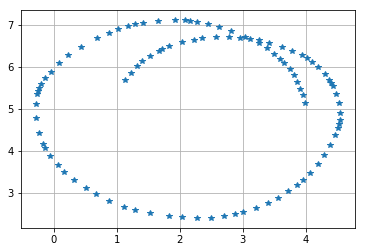

In [50]:
### Simulation Model for differential drive robot: 

# To decide: 

# Go for 100 x 100 grid:

# 1. Time range for simulation: 10 secs with 0.1 second time samples
t0 = 0 
tf = 10 
delT = 0.1

tVec = np.arange(t0, tf ,delT)


# 2. Initial state: 
x0 = np.array([ 4 , 5 , np.pi/2]).reshape((3,1))

# 3. Known target point: 
tgt = np.array([8,8]).reshape((2,1))

# 4. Input values - (Control Commands): 
 
# vel = 0.4*np.sin(2*np.pi*tVec)
vel = 2*np.ones((1,len(tVec)))
#omega = 0.05*(6*tVec - tVec**2)
omega = 0.9*np.ones((1,len(tVec)))



# 5. Process Noise simulation:
velStdDev = 0.8  # m/s
omegaStdDev = 0.25 # rad

epsVel =   velStdDev*np.random.randn(1,len(tVec))
epsOmega = omegaStdDev*np.random.randn(1,len(tVec))


uT = np.vstack((vel,omega))

uVec = np.vstack((vel + epsVel , omega + epsOmega))

# History of simulation values: 
xTrueHist = np.zeros((3,len(tVec) + 1))



def x_dot(t, x , uVec, tVec): 
    
    x_dot = np.zeros((3,1))
    
    # Interpolate uVec: 
    v = np.interp(t, tVec, uVec[0,:])
    omega = np.interp(t, tVec, uVec[1,:])
    
    x_dot[0] = v*np.cos(x[2])
    x_dot[1] = v*np.sin(x[2])
    x_dot[2] = omega
    
    return x_dot


from scipy.integrate import ode
from matplotlib import pyplot as plt

r = ode(x_dot)

r.set_initial_value(x0, t0)

r.set_f_params(uVec,tVec)

count =0

time = []

while r.successful() and r.t < tf:
    
    r.integrate(r.t+delT)
    
    xTrueHist[:,count] = r.y.reshape((3,))
    time.append(r.t)
    
    count +=1
    
    
plt.plot(xTrueHist[0], xTrueHist[1], '*')
plt.grid()

nSamples = xTrueHist.shape[1]

print (nSamples)

# Simulate Measurements: 
zTrue = np.zeros((2, nSamples))

for i in range(0,nSamples):
    zTrue[:,i] = z_func(xTrueHist[:,i], tgt).reshape((2,))
    

stdDevRange = 0.2  # meters
stdDevBearing = 0.1 # rad

epsRange = stdDevRange*np.random.randn(1,nSamples)
epsBearing = stdDevBearing*np.random.randn(1,nSamples)

measNoise = np.vstack((epsRange, epsBearing))


zMeas = zTrue + measNoise

print (zMeas[:,0])


In [21]:
# For loop to run the EKF: 

# Initialize EKF for Unicycle Model: 
# Process noise covaraince matrix: Diagonal: 
Q = 

# Measurement noise covaraince matrix: 
R = 

# Initial state covariance: 
P0 = 

# Number of Runge-Kutta Integration steps: 
nRK = 


Unicycle_EKF = EKF(delT, Q, R, x0, P0 , x_dot_func, z_func, F_func, D_func, H_func, nRK)


for


[[ 4.15650325]
 [ 4.96919126]
 [ 9.19351675]]
